In [1]:
import qutip as q
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

from animation import plot_cavity_evolution
from definitions import *

import itertools

from scipy.special import erf
from functools import partial


## Hamiltonians with activation functions for the gates
$H = H_0 + f(t)U_1+ g(t)V_1 + h(t)W_1$ 

where 
- $H_0=\hbar\frac{\omega_a}{2}\sigma_z + \hbar\omega_c a^\dagger a$
- $U_k = u_k \hat{x}\hat{\sigma_y}$
- $V_k = v_k \hat{p}\hat{\sigma_x}$
- $W_k = w_k \hat{x}\hat{\sigma_y}$

In [2]:
#Jacobs gates

U = x*sy
V = p*sx
W = x*sy

#Jacobs gate parameters

def us(k : int, M: int, method = 1):
    
    us1 = {1: [0], 2: [0,0.045], 3: [0,0.053, 0.033], 4: [0,0.038,0.027,0.015]}
    us2 = {1: [0], 2: [0,0.043], 3: [0,0.04, 0.026], 4: [0,0.024,0.015,0.008]}
    if method == 1: 
        return us1[M][k]
    else: 
        return us2[M][k]  

def vs(k : int, M: int): 
    if k == 0:
        return -np.sqrt(np.pi)*2**(M-1)
    else: 
        return np.sqrt(np.pi)*2**(M-(k+1))

def ws(k :int, M: int):
    if k == M:
        return np.sqrt(np.pi)/4
    else: 
        return -np.sqrt(np.pi)/4*2**(-(M-(k+1)))


def get_Hlist(M : int):
    """Get gate list for M rounds
    """

    U_list = [us(k,M)*U for k in range(M)]
    V_list = [vs(k,M)*V for k in range(M)] 
    W_list = [ws(k,M)*W for k in range(M)]
    
    H_list = itertools.chain.from_iterable([[us(k,M)*U, vs(k,M)*V, ws(k,M)*W] for k in range(M)])
    return list(H_list)

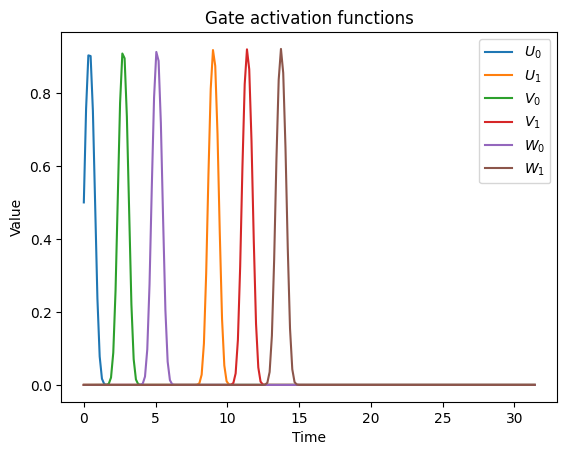

In [11]:
#Activation function
M = 2

tau = 0.5*oma
dtau = 1*oma
tau_w = 3*tau + 3*dtau + 2*tau


def activate(t0, tf, z, t):
    """Activation function for the cavity-atom interaction
    
    t0: activation time
    tf: deavtivation time
    z: sensitivity 
    """
    return 0.25*(1+erf(z*(t-t0)))*(1+erf(-z*(t-tf)))


def t0(gate : int, k : int):
    return k*tau_w + gate*(tau+dtau)
    
def tf(gate: int, k: int):
    return t0(gate, k) + tau

from functools import partial

Hcoeffs = [partial(activate, t0(gate, k), tf(gate, k), 2*omc) for gate in range(3) for k in range(M)]
labels = [f'$U_{k}$' if g == 0 else f'$V_{k}$' if g == 1 else f'$W_{k}$' for g in range(3) for k in range(M)]

t = np.linspace(0,10*np.pi,200)
for i, fun in enumerate(Hcoeffs):
    plt.plot(t, fun(t), label = labels[i] )

plt.legend()
plt.title('Gate activation functions')
plt.ylabel('Value')
plt.xlabel('Time')
plt.show()

In [12]:
def qed_solver(oma, omc, gamma=0, alpha = 0, zeta = 0, t = np.linspace(0,10*pi,201)):

    H0 = hbar*oma/2*sz + hbar*omc*ad*a
    Hlist = get_Hlist(M)
    Htimedep =  list(map(list, zip(Hlist, Hcoeffs)))


    H = [H0, *Htimedep]
    if gamma > 0:
        c_ops = [np.sqrt(gamma) * sm]
    else:
        c_ops = []
    
    #Initial state (squeeze the coherent state with zero displacement)
    rho0 = q.tensor(q.basis(2,0), q.squeeze(N, zeta) @ q.coherent(N, alpha))
    res = q.mesolve(H, rho0, c_ops = c_ops, tlist= t)

    return res

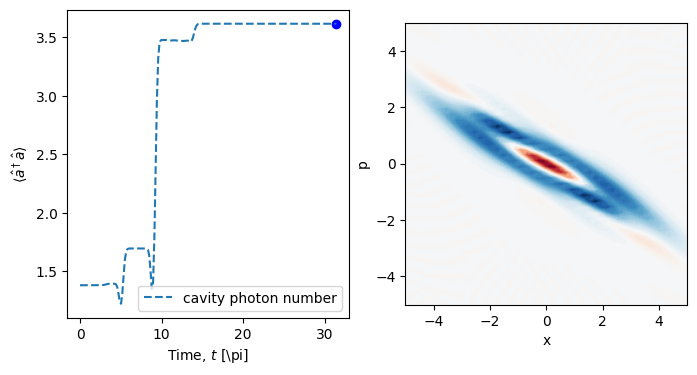

In [14]:
ani = plot_cavity_evolution(qed_solver(oma,omc,0,0,1))
HTML(ani.to_html5_video())